In [1]:
from pytorch_lightning import Trainer
from catinous.CatsinomModelGramCache import CatsinomModelGramCache
from catinous.CatsinomDataset import CatsinomDataset
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
import sklearn 
import pytorch_lightning.logging as pllogging
from sklearn.metrics import confusion_matrix, auc, roc_curve
import torch
import pandas as pd
import seaborn as sns
import pickle
from py_jotools import mut
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
def get_default_hparams():
    hparams = dict()
    hparams['root_dir'] = '/project/catinous/cat_data/'
    hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
    hparams['batch_size'] = 8
    hparams['training_batch_size'] = 8
    hparams['transition_phase_after'] = 0.7
    hparams['cachemaximum'] = 64
    hparams['use_cache'] = True
    hparams['random_cache'] = True
    hparams['force_misclassified'] = False
    hparams['direction'] = 'lr->hr'
    
    return hparams

In [3]:
basemodel = '/project/catinous/trained_models/lrbase_iterations.pt'
i=2
hparams = get_default_hparams()
model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

model.load_state_dict(torch.load(basemodel))

logger = pllogging.TestTubeLogger('catinous_log_iterations', name='continuous_random_cache')
trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=10, show_progress_bar=False)
trainer.fit(model)
torch.save(model.state_dict(), '/project/catinous/trained_models/continuous_random_cache_run_'+str(i)+'.pt')

for ci in model.trainingscache.cachelist:
    ci.img = None
    ci.current_grammatrix = None
pickle.dump(model.trainingscache.cachelist, open('/project/catinous/trained_cache/continuous_random_cache_run_'+str(i)+'.pkl', 'wb'))

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

In [ ]:
#testing different transition phases
basemodel = '/project/catinous/trained_models/lrbase_iterations.pt'

transitionphase = [0.3, 1.0]

for tp in transitionphase:
    for i in range(3):
        hparams = get_default_hparams()
        hparams['transition_phase_after'] = tp
        
        expname = 'continous_random_cache_transphase_' + str(tp)
        
        model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

        model.load_state_dict(torch.load(basemodel))

        logger = pllogging.TestTubeLogger('catinous_log_iterations', name=expname)
        trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=10, show_progress_bar=False)
        trainer.fit(model)
        torch.save(model.state_dict(), '/project/catinous/trained_models/' + expname + '_run_'+str(i)+'.pt')

        pickle.dump(model.trainingscache.cachelist, open('/project/catinous/trained_cache/' + expname + '_run_'+str(i)+'.pkl', 'wb'))

        trainer = None
        model = None
        trainer = None
        torch.cuda.empty_cache()

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

In [ ]:
#testing different cache sizes
cache_size = [16, 128, 256]

for cs in cache_size:
    for i in range(5):
        hparams = get_default_hparams()
        hparams['cachemaximum'] = cs
        
        expname = 'continous_random_cache_cachesize_' + str(cs)
        
        model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

        model.load_state_dict(torch.load(basemodel))

        logger = pllogging.TestTubeLogger('catinous_log_iterations', name=expname)
        trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=10, show_progress_bar=False)
        trainer.fit(model)
        torch.save(model.state_dict(), '/project/catinous/trained_models/' + expname + '_run_'+str(i)+'.pt')

        pickle.dump(model.trainingscache.cachelist, open('/project/catinous/trained_cache/' + expname + '_run_'+str(i)+'.pkl', 'wb'))

        trainer = None
        model = None
        torch.cuda.empty_cache()

In [2]:
i=1
hparams = dict()
hparams['root_dir'] = '/project/catinous/cat_data/'
hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
hparams['batch_size'] = 8
hparams['training_batch_size'] = 8
hparams['transition_phase_after'] = 0.7
hparams['cachemaximum'] = 64
hparams['use_cache'] = True
hparams['random_cache'] = True
model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

model.load_state_dict(torch.load('/project/catinous/trained_models/lrbase_iterations.pt'))

logger = pllogging.TestTubeLogger('catinous_log_iterations', name='gramcontinuous_random_cache_misclassification')
trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=10, show_progress_bar=False)
trainer.fit(model)
torch.save(model.state_dict(), '/project/catinous/trained_models/gramcontinuous_random_cache_trainmisclassified_run_'+str(i)+'.pt')

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

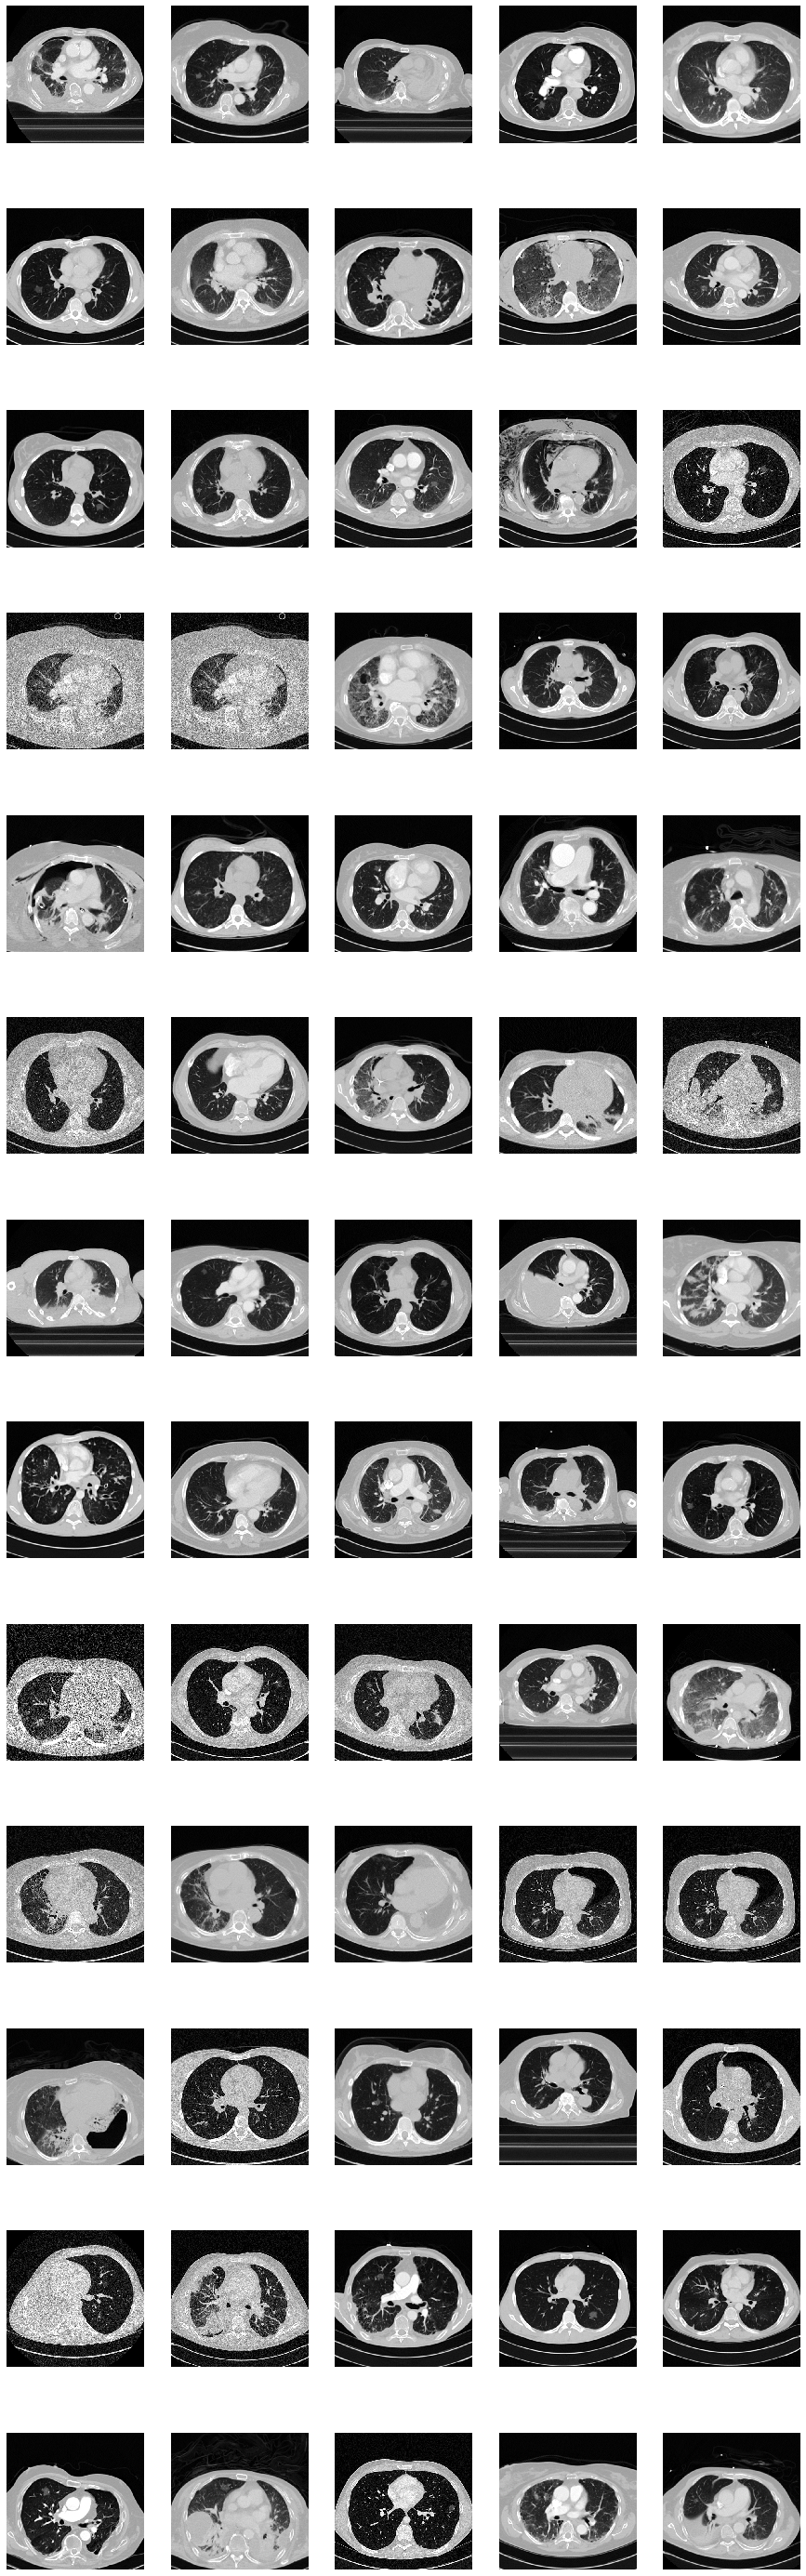

In [3]:
imgs = [x.img.cpu().numpy()[0,0,:,:] for x in model.trainingscache.cachelist]
mut.mimshow(np.asarray(imgs), nslic=65)